## Predicting Cost of Caterpillar<sup>TM</sup> Tube Assemblies.

In [127]:
import eli5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from category_encoders import OrdinalEncoder
from eli5.sklearn import PermutationImportance
from glob import glob
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

In [128]:
# Set display options.
%matplotlib inline
pd.set_option('display.max_columns', 250)

In [129]:
# Get data into dataframes.
trainval = pd.read_csv('data/competition_data/train_set.csv')
test = pd.read_csv('data/competition_data/test_set.csv')

In [130]:
trainval.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [131]:
# Ensure dates are datetimes.
trainval['quote_date'] = pd.to_datetime(trainval['quote_date'], infer_datetime_format=True)
test['quote_date'] = pd.to_datetime(test['quote_date'], infer_datetime_format=True)

# Is our data chronological?
trainval['quote_date'].describe()

count                   30213
unique                   1781
top       2013-10-01 00:00:00
freq                     2877
first     1982-09-22 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

In [132]:
test['quote_date'].describe()

count                   30235
unique                   1778
top       2013-09-01 00:00:00
freq                     2992
first     1985-11-16 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

In [133]:
# Dates are concurrent. The sets must be separated in another way.
set(trainval['tube_assembly_id'].unique()) & set(test['tube_assembly_id'].unique())

set()

In [134]:
# Assembly id is not shared, split training data into train and validate by assembly id.
trainval_assemblies = trainval['tube_assembly_id'].unique()
test_assemblies = test['tube_assembly_id'].unique()

train_tubes, val_tubes = train_test_split(trainval_assemblies, random_state=42)

train = trainval[trainval['tube_assembly_id'].isin(train_tubes)]
val = trainval[trainval['tube_assembly_id'].isin(val_tubes)]
train.shape, val.shape, test.shape

((22628, 8), (7585, 8), (30235, 8))

In [135]:
# Our error metric will be Root Mean Squared Log Error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [136]:
# Use the cost mean to make our cost prediction.
target = 'cost'
y_train = train[target]
y_val = val[target]

y_pred = np.full_like(y_val, fill_value=y_train.mean())
print(f'Validation RMSLE, Mean Baseline: {rmsle(y_val, y_pred)}')

Validation RMSLE, Mean Baseline: 0.9418101276064408


Wrong 94% of the time. We can only do better.

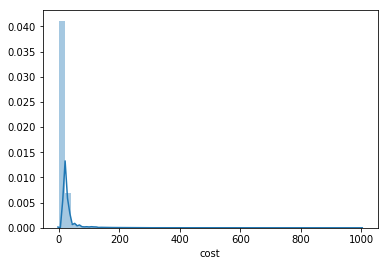

In [137]:
# Check out the distribution of the target, cost.
sns.distplot(y_train);

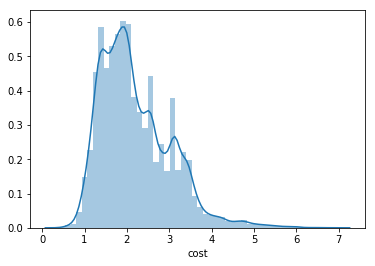

In [138]:
# We can get these into a smaller space by taking the log of each target value.
y_train_log = np.log1p(y_train)
sns.distplot(y_train_log);

#### This is only one of many files proved. Import the rest into a dictionary of dataframes and add usefull information to the training, validation, and testing sets for better predictive power!

Begin combining relational tables.

In [139]:
# Import each file into a dataframe and put em in a dict.
data = {}
for path in glob('data/competition_data/*.csv'):
    df = pd.read_csv(path)
    file = re.search(r'(?<=\\)(.+)(?=[.])', path)
    data[file.group(1)] = df

In [140]:
# List the names of all data frames.
data.keys()

dict_keys(['bill_of_materials', 'components', 'comp_adaptor', 'comp_boss', 'comp_elbow', 'comp_float', 'comp_hfl', 'comp_nut', 'comp_other', 'comp_sleeve', 'comp_straight', 'comp_tee', 'comp_threaded', 'specs', 'test_set', 'train_set', 'tube', 'tube_end_form', 'type_component', 'type_connection', 'type_end_form'])

In [141]:
# Sounds usefull.
data['bill_of_materials'].head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
# Make a tidy dataframe with the 'component_id's accociated with each 'tube assembly_id'.
materials = data['bill_of_materials']
assembly = materials.melt(id_vars='tube_assembly_id',
                           value_vars=[f'component_id_{n}' for n in range(1, 9)])

# Sort and remove NANs and give the column its name back.
assembly = (assembly.sort_values(by='tube_assembly_id')
            .dropna()
            .rename(columns={'value': 'component_id'}))
assembly.head()

,tube_assembly_id,variable,component_id
0,TA-00001,component_id_1,C-1622
21198,TA-00001,component_id_2,C-1629
1,TA-00002,component_id_1,C-1312
2,TA-00003,component_id_1,C-1312
3,TA-00004,component_id_1,C-1312


Sweet

In [143]:
# This also looks promising.
data['components'].head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


In [144]:
# Add to the 'assembly' dataframe.
components = data['components']
assembly_components = assembly.merge(components, how='left')
assembly_components.head()

,tube_assembly_id,variable,component_id,name,component_type_id
0,TA-00001,component_id_1,C-1622,NUT-SWIVEL,CP-025
1,TA-00001,component_id_2,C-1629,SLEEVE-ORFS,CP-024
2,TA-00002,component_id_1,C-1312,NUT-FLARED,CP-028
3,TA-00003,component_id_1,C-1312,NUT-FLARED,CP-028
4,TA-00004,component_id_1,C-1312,NUT-FLARED,CP-028


Nice

In [145]:
# Make a crosstab of this to create a boolean column for each 'component_type_id'.
table = pd.crosstab(assembly_components['tube_assembly_id'],
                   assembly_components['component_type_id'])

# Take 'tube_assembly_id' from index to column.
table = table.reset_index()

# No column name needed.
table.columns.name = ''
table.head()

,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,CP-010,CP-011,CP-012,CP-014,CP-015,CP-016,CP-017,CP-018,CP-019,CP-020,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [146]:
# Concatenate all component dataframes into one.
comp = pd.concat((df for name, df in data.items() if 'comp_' in name), sort=False)

# Choose the features we want from components.
columns = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight', 'plating', 'groove']
comp = comp[columns]

# Make columns into int/bool
comp['orientation'] = (comp['orientation'] == 'Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature'] == 'Yes').astype(int)
comp['plating'] = (comp['plating'] == 'Yes').astype(int)
comp['groove'] = (comp['groove'] == 'Yes').astype(int)

#Fill any missing weights with the median.
comp['weight'] = comp['weight'].fillna(comp['weight'].median())

comp.head()

,component_id,component_type_id,orientation,unique_feature,weight,plating,groove
0,C-0005,CP-028,0,0,0.206,0,0
1,C-0006,CP-028,0,0,0.083,0,0
2,C-1435,CP-028,0,0,0.023,0,0
3,C-1546,CP-028,0,0,0.026,0,0
4,C-1583,CP-028,0,0,0.256,0,0


Looking good

In [147]:
# Aggregate features for each tube_assembly_id.
materials['components_total'] = sum([materials[f'quantity_{n}'].fillna(0) for n in range(1, 9)])
materials['components_distinct'] = sum([materials[f'component_id_{n}'].notnull().astype(int) for n in range(1, 9)])
materials['orientation'] = 0
materials ['unique_feature'] = 0
materials['weight'] = 0
materials['plating'] = 0
materials['groove'] = 0

# Merge components for each 'component_id_' with materials.
for n in range(1, 9):
    materials = materials.merge(comp,
                                left_on=f'component_id_{n}',
                                right_on='component_id',
                                how='left',
                                suffixes=('', f'_{n}'))

# Fill all NANs with 0.
for col in materials:
    if ('orientation' in col or 
        'unique_feature' in col or 
        'weight' in col or
        'plating' in col or
        'groove' in col):
        materials[col] = materials[col].fillna(0)

# Sum features for each tube_assembly_id.
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1, 9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1, 9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1, 9))
materials['plating'] = sum(materials[f'plating_{n}'] for n in range(1, 9))
materials['groove'] = sum(materials[f'groove_{n}'] for n in range(1, 9))

materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,components_total,components_distinct,orientation,unique_feature,weight,plating,groove,component_id,component_type_id,orientation_1,unique_feature_1,weight_1,plating_1,groove_1,component_id_2,component_type_id_2,orientation_2,unique_feature_2,weight_2,plating_2,groove_2,component_id_3,component_type_id_3,orientation_3,unique_feature_3,weight_3,plating_3,groove_3,component_id_4,component_type_id_4,orientation_4,unique_feature_4,weight_4,plating_4,groove_4,component_id_5,component_type_id_5,orientation_5,unique_feature_5,weight_5,plating_5,groove_5,component_id_6,component_type_id_6,orientation_6,unique_feature_6,weight_6,plating_6,groove_6,component_id_7,component_type_id_7,orientation_7,unique_feature_7,weight_7,plating_7,groove_7,component_id_8,component_type_id_8,orientation_8,unique_feature_8,weight_8,plating_8,groove_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,0.0,1.0,0.048,0.0,0.0,C-1622,CP-025,0.0,0.0,0.036,0.0,0.0,C-1629,CP-024,0.0,1.0,0.012,0.0,0.0,NaN,NaN,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,0.0,0.0,C-1312,CP-028,0.0,0.0,0.009,0.0,0.0,NaN,NaN,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,0.0,0.0,C-1312,CP-028,0.0,0.0,0.009,0.0,0.0,NaN,NaN,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,0.0,0.0,C-1312,CP-028,0.0,0.0,0.009,0.0,0.0,NaN,NaN,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,0.0,1.0,0.210,0.0,0.0,C-1624,CP-025,0.0,0.0,0.035,0.0,0.0,C-1631,CP-024,0.0,1.0,0.026,0.0,0.0,C-1641,CP-014,0.0,0.0,0.149,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [148]:
data['tube'].head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [149]:
tube = data['tube']

In [150]:
ends = data['tube_end_form']
ends['forming'] = (ends['forming'] == 'Yes').astype(int)
ends.columns = ['end_a', 'forming']
ends.head()

,end_a,forming
0,EF-001,1
1,EF-002,0
2,EF-003,0
3,EF-004,0
4,EF-005,1


In [151]:
specs = data['specs'].copy()
specs = specs.fillna(0)
specs = specs.set_index('tube_assembly_id')
specs = specs.applymap(lambda x: 0 if x == 0 else 1)
specs['total_specs'] = sum(specs[f'spec{n}'] for n in range(1, 11))
specs = specs.reset_index()
specs = specs[['tube_assembly_id', 'total_specs']]
specs.head()

,tube_assembly_id,total_specs
0,TA-00001,0
1,TA-00002,0
2,TA-00003,0
3,TA-00004,0
4,TA-00005,0


#### Put it all together.

In [152]:
# Split data as before.
trainval = data['train_set']
test = data['test_set']

trainval_tubes = trainval['tube_assembly_id'].unique()
train_ass, val_ass = train_test_split(trainval_tubes, random_state=42)

train = trainval[trainval['tube_assembly_id'].isin(train_ass)]
val = trainval[trainval['tube_assembly_id'].isin(val_ass)]

In [153]:
def clean(dataframe):
    """Final data cleaning before modeling.
    
    Make month and year columns.
    
    Merge table, materials, ends, specs, and tube dataframes with dataframe.
    Drop all redundant columns.
    """
    
    df = dataframe.copy()
    
    # Create month and year columns.
    df['quote_date'] = pd.to_datetime(df['quote_date'], infer_datetime_format=True)
    df['quote_year'] = df['quote_date'].dt.year
    df['quote_month'] = df['quote_date'].dt.month
    
    #Merge data.
    df = (df.merge(table, how='left')
         .merge(materials, how='left')
         .merge(tube, how='left')
         .merge(specs, how='left')
         .merge(ends, how='left')
         .fillna(0))
    
    #Drop redundant columns.
    drops = [['quote_date', 'tube_assembly_id'],
             [col for col in df.columns if 'weight_' in col],
             [col for col in df.columns if 'plating_' in col],
             [col for col in df.columns if 'groove_' in col],
             [col for col in df.columns if 'CP' in col],
             [col for col in df.columns if 'component_id' in col],
             [col for col in df.columns if 'quantity_' in col],
             [col for col in df.columns if 'unique_feature_' in col],
             [col for col in df.columns if 'orientation_' in col]
            ]
    
    for cat in drops:
        df = df.drop(columns=cat)

    return df

In [154]:
# Apply the function to each dataset.
train = clean(train)
val = clean(val)
test = clean(test)
all_train = clean(trainval)

In [155]:
# Only the 'weight' column should remain.
[col for col in train.columns if 'weight' in col]

['weight']

Awesome

In [156]:
val.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,quote_year,quote_month,OTHER,components_total,components_distinct,orientation,unique_feature,weight,plating,groove,component_type_id,component_type_id_2,component_type_id_3,component_type_id_4,component_type_id_5,component_type_id_6,component_type_id_7,component_type_id_8,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,total_specs,forming
0,S-0066,0,0,Yes,1,21.905933,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
1,S-0066,0,0,Yes,2,12.341214,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
2,S-0066,0,0,Yes,5,6.601826,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
3,S-0066,0,0,Yes,10,4.687770,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
4,S-0066,0,0,Yes,25,3.541561,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0


In [157]:
train.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,quote_year,quote_month,OTHER,components_total,components_distinct,orientation,unique_feature,weight,plating,groove,component_type_id,component_type_id_2,component_type_id_3,component_type_id_4,component_type_id_5,component_type_id_6,component_type_id_7,component_type_id_8,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,total_specs,forming
0,S-0066,0,0,Yes,1,21.972702,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
1,S-0066,0,0,Yes,2,12.407983,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
2,S-0066,0,0,Yes,5,6.668596,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
3,S-0066,0,0,Yes,10,4.754539,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0
4,S-0066,0,0,Yes,25,3.608331,2013,7,0.0,2.0,1,0.0,0.0,0.009,0.0,0.0,CP-028,0,0,0,0,0,0,0,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,0,1.0


This looks like usefull information!

In [158]:
# Check that one of those columns contains something other than a zero.
train['unique_feature'].value_counts()

0.0    11104
1.0    10792
2.0      732
Name: unique_feature, dtype: int64

Looks pretty good

In [159]:
# Check that we still have an equal number of columns for each set.
train.shape, val.shape, test.shape

((22628, 41), (7585, 41), (30235, 41))

In buisness

In [160]:
# Isolate the target value from the train and validation sets, then remove the column.
target = 'cost'
y_target = train[target]
y_val = val[target]
y_all = all_train[target]

X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
X_all = all_train.drop(columns=target)

# Scale targets with log function as above.
y_target_log = np.log1p(y_target)
y_val_log = np.log1p(y_val)
y_all_log = np.log1p(y_all)


In [161]:
# Check that we still have an equal number of columns for each set.
X_train.shape, X_val.shape, X_test.shape

((22628, 40), (7585, 40), (30235, 40))

In [162]:
# Check for repeated column names.
assert(sum([X_train.columns.tolist().count(string) for string in X_train.columns]) == len(X_train.columns.tolist()))

In [163]:
# Use OrdinalEncoding for Random Forest Resgression.
encoder = OrdinalEncoder()
X_train_ = encoder.fit_transform(X_train.values)
X_val_ = encoder.transform(X_val.values)
X_test_ = encoder.transform(X_test.values)
X_all_ = encoder.fit_transform(X_all.values)

In [164]:
# Prepare model.
eval_set = [(X_train_, y_train_log),
            (X_val_, y_val_log)]

model = XGBRegressor(n_estimators=2000,
                    n_jobs=-1,
                    verbose=0)

model.fit(X_train_,
          y_train_log,
          eval_set=eval_set,
          eval_metric='rmse',
          early_stopping_rounds=50,
          verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbose=0)

In [165]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [166]:
# Make a prediction!
y_pred_log = model.predict(X_val_)
y_pred = np.expm1(y_pred_log)
print(f'Validation RMSE: {rmse(y_val, y_pred)}')

#@And submit it to kaggle!
y_pred_log = model.predict(X_test_)
y_pred = np.expm1(y_pred_log)
submission = pd.read_csv('sample_submission.csv')
submission['cost'] = y_pred
submission.to_csv('sub_7.csv', index=False)

Validation RMSE: 23.812508451602614


Wrong 24% of the time. Much improved!

##### Look at what features are important to the model and drop some if they aren't helpfull.

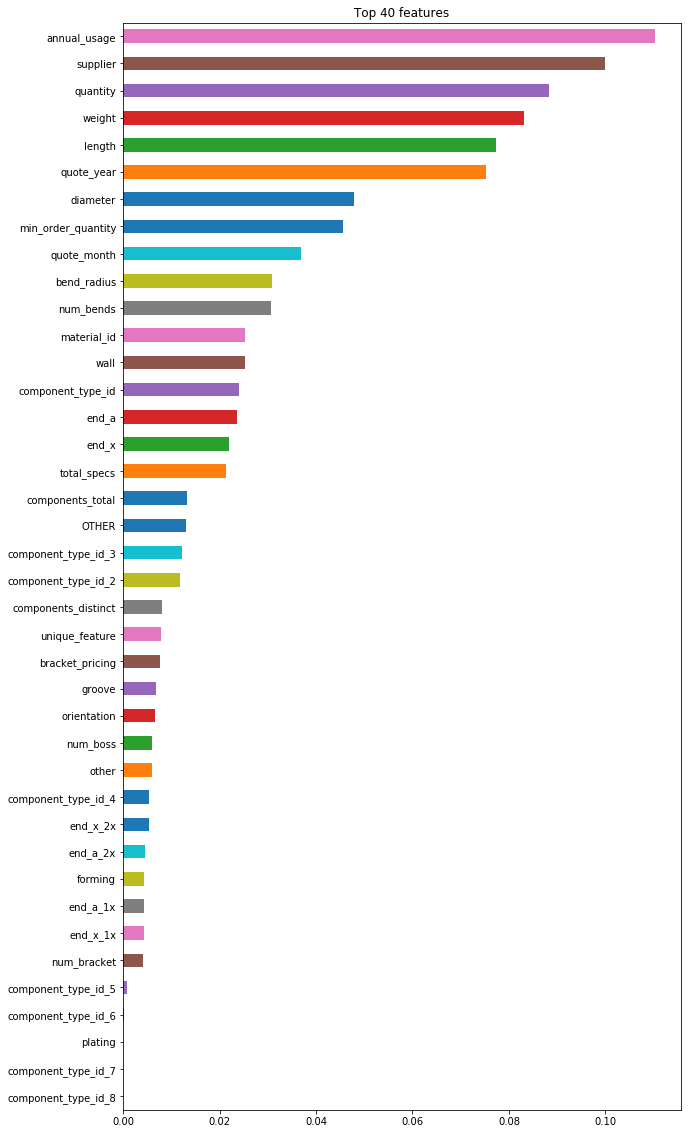

In [167]:
# Get feature importances.
importances = pd.Series(model.feature_importances_, X_train.columns)

# Plot them.
n = len(X_train_.columns)
plt.figure(figsize=(10, n / 2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [ ]:
# See what a more robust method thinks of which feature is important.
permuter = PermutationImportance(model,
                                 scoring='neg_mean_squared_error',
                                 cv='prefit',
                                 n_iter=5,
                                 random_state=42)

permuter.fit(X_val_, y_val_log)
feature_names = X_val.columns.tolist()

# Using a DataFrame as it's easier to read.

# eli5.show_weights(permuter, top=None, feature_names=feature_nameus)
feature_import = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
fig = plt.figure(figsize=(10, len(feature_import) / 2))
ax = fig.gca()
feature_import.sort_values(ascending=True).plot.barh(ax=ax)


Explore feature importance by Drop-Column Importance.

In [ ]:
# Examine running the model with and without the 'annual_usage' feature.
column = 'annual_usage'

# Fit without column.
model = XGBRegressor(n_estimators=1000, 
                     n_jobs=-1, 
                     random_state=42)

# Find index of 'column'.
for i, col in enumerate(X_val.columns.tolist()):
    if col == column:
        break

# Drop integer column encoded as 'column'.
X_train_d = X_train_.drop(columns=i)
X_val_d = X_val_.drop(columns=i)

model.fit(X_train_d, y_train_log)
y_pred_log = model.predict(X_val_d)

y_pred = np.expm1(y_pred_log)
score_without = rmse(y_val, y_pred)
print(f'Validation RMSE without \'{column}\': {score_without}')

# Fit with column.
model = XGBRegressor(n_estimators=1000, 
                     n_jobs=-1, 
                     random_state=42)

model.fit(X_train_, y_train_log)
y_pred_log = model.predict(X_val_)

y_pred = np.expm1(y_pred_log)
score_with = rmse(y_val, y_pred)

print(f'Validation RMSE with \'{column}\': {score_with}')
print(f'Drop-Column Importance for \'{column}\': {score_without - score_with}')

Explore feature importance with Permutation Importance.

In [ ]:
# Examine the effect of the 'quantity' feature.
feature = 'quantity'
for i, col in enumerate(X_val.columns.tolist()):
    if col == feature:
        break
X_val_[i].head()

In [ ]:
# Check out the distribution of the column.
X_val_[i].describe()

In [ ]:
# Make column into random noise with the same distribution of the original column by using a permutation of the column data.
X_val_p = X_val_.copy()
X_val_p[i] = np.random.permutation(X_val_[i])
X_val_p[i].head()

In [ ]:
# Permuted column retains the same distribution.
X_val_p[i].describe()

In [ ]:
# Make a prediction with the permuted feature.
y_pred_log = model.predict(X_val_p)
y_pred = np.expm1(y_pred_log)
score_p = rmse(y_val, y_pred)
print(f'Validation RMSE with \'{feature}\': {score_with}')
print(f'Validation RMSE with \'{feature}\' permuted: {score_p}')
print(f'Permutation Importance: {score_p - score_with}')

In [ ]:
# Repeat with a different column.
feature = 'annual_usage'
for i, col in enumerate(X_val.columns.tolist()):
    if col == feature:
        break

X_val_p = X_val_.copy()
X_val_p[i] = np.random.permutation(X_val_[i])
y_pred_log = model.predict(X_val_p)

y_pred = np.expm1(y_val, y_pred)
score_p = rmse(y_val_log, y_pred_log)

print(f'Validation RMSE with \'{feature}\': {score_with}')
print(f'Validation RMSE with \'{feature}\' permuted: {score_p}')
print(f'Permutation Importance: {score_p - score_with}')

Strange result. Not sure what to think of that.

Use Importances for feature selection.

In [ ]:
print(f'Shape before removing features: {X_train.shape}')

Remove features with low feature importance.

In [ ]:
# Create a boolean mask indicating if a feature's importance is greater than zero.
mask = permuter.feature_importances_ > 0

# Use mask to filter columns.
features = X_train.columns[mask]
X_train = X_train[features]
print(f'Shape after removing low imortance features: {X_train.shape}')

# Apply filtered features to all sets.
X_val = X_val[features]
X_test = X_test[features]
X_all = X_all[features]

In [ ]:
# Train a new model with low importance features removed.
encoder1 = OrdinalEncoder()
X_train_enc = encoder1.fit_transform(X_train.values)
X_val_enc = encoder1.transform(X_val.values)
X_test_enc = encoder1.transform(X_test.values)
X_all_enc = encoder1.fit_transform(X_all.values)

eval_set = [(X_train_enc, y_train_log),
            (X_val_enc, y_val_log)]

model = XGBRegressor(n_estimators=2000,
                     n_jobs=-1,
                     random_state=42,
                     verbose=0)

model.fit(X_train_enc,
          y_train_log,
          eval_set=eval_set,
          eval_metric='rmse',
          early_stopping_rounds=50,
          verbose=0)

y_pred_log = model.predict(X_val_enc)

y_pred = np.expm1(y_pred_log)
error = rmse(y_val, y_pred)
print(f'Validation RMSE = {error}')

In [ ]:
y_pred_log = model.predict(X_test_enc)
y_pred = np.expm1(y_pred_log)
submission = pd.read_csv('sample_submission.csv')
submission['cost'] = y_pred
submission.to_csv('sub_10.csv', index=False)

Getting better!


![better](better.png)

In [ ]:
# Plot partial dependence of 'quantity' feature.
feature = 'quantity'
for i, col in enumerate(X_val.columns):
    if col == feature:
        break

isolated = pdp_isolate(model=model,
                      dataset=X_val_enc,
                      model_features=X_val_enc.columns,
                      feature=i)
pdp_plot(isolated, feature_name=feature);

In [ ]:
# Plot partial dependence of 'weight' feature.
feature = 'weight'
for i, col in enumerate(X_val.columns):
    if col == feature:
        break

isolated = pdp_isolate(model=model, 
                       dataset=X_val_enc,
                       model_features=X_val_enc.columns,
                       feature=i)
pdp_plot(isolated, feature_name=feature);

In [ ]:
# Plot interaction of 'plating' and 'quantity' features.
features = {'plating': 0, 'quantity': 0}
for i, col in enumerate(X_val.columns):
    if col in features.keys():
        features[col] = i

interaction = pdp_interact(model=model,
                           dataset=X_val_enc,
                           model_features=X_val_enc.columns,
                           features=list(features.values()))
pdp_interact_plot(interaction, plot_type='grid', feature_names=list(features.keys()));

# plt.savefig('interact.png')

This is respectable. Tune model's hyperparameters to wring some more predictive power from the data.

In [60]:
pipeline = make_pipeline(OrdinalEncoder(),
                         XGBRegressor(random_state=42, 
                                      early_stopping_rounds=50,
                                      verbose=0,
                                      eval_set=eval_set))

params = {'xgbregressor__gamma': range(10),
          'xgbregressor__max_depth': range(3, 33, 3),
          'xgbregressor__n_estimators': range(100, 2000, 100),
          'xgbregressor__learning_rate': [(1 / x) for x in [10, 20, 100, 1000, 10000]]}

rando = RandomizedSearchCV(pipeline, 
                           params, 
                           cv=3, 
                           n_iter=25, 
                           verbose=10,
                           scoring='neg_mean_squared_log_error',              
                           return_train_score=True,
                           n_jobs=-1)
rando.fit(X_all_enc, 
          y_all_log)

print('Best hyperparameters', rando.best_params_)
print('Cross-validation RMSLE', np.sqrt(-rando.best_score_))


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 56.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 74.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 96.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 107.6min finished


Best hyperparameters {'xgbregressor__n_estimators': 1400, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__gamma': 0}
Cross-validation RMSLE 0.08301230727258031


In [63]:
new_params = {'xgbregressor__max_depth': range(25, 36, 5),
              'xgbregressor__learning_rate': np.linspace(0.001, 0.1, 3),
              'xgbregressor__gamma': np.linspace(.001, .01, 3)}

model = rando.best_estimator_

grid = GridSearchCV(model,
                    new_params,
                    n_jobs=-1,
                    verbose=10,
                    scoring='neg_mean_squared_log_error',
                    return_train_score=True)

grid.fit(X_all_enc, 
         y_all_log)
 
print(f'Best hyperparameters: {grid.best_params_}')
print(f'Cross-Validation RMSLE: {np.sqrt(-grid.best_score_)}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 78.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 108.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 134.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 172.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 195.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 245.3min finished


Best hyperparameters: {'xgbregressor__gamma': 0.01, 'xgbregressor__learning_rate': 0.0505, 'xgbregressor__max_depth': 35}
Cross-Validation RMSLE: 0.09117273556168061


In [64]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bytree=1,
                              early_stopping_rounds=50,
                              eval_set=[(       0     1   2   3    4     5   6    7    8    9    10   11   12   13  \
0       1     0   0   1    1  2013   7  0.0  0.0  0.0  0...
7582    3.387290
7583    1.938059
7584    2.955647
Name: cost, Length: 7585, dtype: float64)],
                              gamma=0.01, learning_rate=0.0505,
                              max_delta_step=0, max_depth=35,
                              min_child_weight=1, missing=None,
                              n_estimato

In [65]:
y_pred_log = grid.best_estimator_.predict(X_test_enc)
y_pred = np.expm1(y_pred_log)
submission = pd.read_csv('sample_submission.csv')
submission['cost'] = y_pred
submission.to_csv('sub_8.csv', index=False)